In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.optim as optim


In [12]:
train_data1 = np.load('data0.npy')
lab_data = np.load('lab0.npy')

In [13]:
print("data shape: ", train_data1.shape)
print("label shape: ", lab_data.shape)

data shape:  (10000, 40, 168)
label shape:  (10000,)


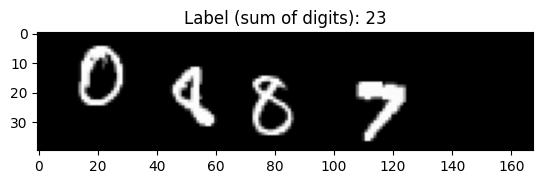

In [15]:
i = 35
plt.imshow(train_data1[i], cmap = 'gray')
plt.title(f"Label (sum of digits): {lab_data[i]}")
plt.show()

In [29]:
class SumOfDigitsDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # image shape: (H, W) in numpy
        img = self.images[idx].astype(np.float32)  # convert to float32
        lbl = int(self.labels[idx])

        # add channel dimension: (1, H, W)
        img = np.expand_dims(img, axis=0)  # from (H, W) -> (1, H, W)

        # If you want to normalize (0..1):
        img /= 255.0

        # Convert to torch tensors
        img_tensor = torch.from_numpy(img)    # shape: (1, H, W)
        lbl_tensor = torch.tensor(lbl, dtype=torch.long)

        # Optional transform
        if self.transform:
            img_tensor = self.transform(img_tensor)

        return img_tensor, lbl_tensor





In [30]:
# Create dataset
dataset = SumOfDigitsDataset(train_data1, lab_data)
print("Dataset size:", len(dataset))

Dataset size: 10000


In [31]:
from sklearn.model_selection import train_test_split

In [32]:
train_indices, val_indices = train_test_split(
    np.arange(len(dataset)), test_size=0.2, random_state=42
)


In [33]:
# Subset the original dataset
train_subset = torch.utils.data.Subset(dataset, train_indices)
val_subset   = torch.utils.data.Subset(dataset, val_indices)

print("Train size:", len(train_subset), "Val size:", len(val_subset))


Train size: 8000 Val size: 2000


In [34]:
batch_size = 32

train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_subset, batch_size=batch_size, shuffle=False)


In [35]:
num_classes = lab_data.max() + 1
print("Number of classes (0..{}) = {}".format(lab_data.max(), num_classes))


Number of classes (0..36) = 37


In [36]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # After two poolings, if input is HxW,
        # output will be (H/4)x(W/4) in spatial dimension.
        # Let’s figure out the dimension for the linear layer:
        # But to keep it simple, we’ll do this dynamically in forward() with a flatten.

        self.fc1 = nn.Linear(64 *  ( (dataset[0][0].shape[1]//4 ) * (dataset[0][0].shape[2]//4 )), 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        # x shape: (B, 1, H, W)
        x = self.conv1(x)       # (B, 32, H, W)
        x = nn.functional.relu(x)
        x = self.pool1(x)       # (B, 32, H/2, W/2)

        x = self.conv2(x)       # (B, 64, H/2, W/2)
        x = nn.functional.relu(x)
        x = self.pool2(x)       # (B, 64, H/4, W/4)

        # Flatten
        x = x.view(x.size(0), -1)  # (B, 64*(H/4)*(W/4))

        x = self.fc1(x)         # (B, 128)
        x = nn.functional.relu(x)
        x = self.fc2(x)         # (B, num_classes)

        return x

model = SimpleCNN(num_classes=num_classes)
print(model)


SimpleCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=26880, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=37, bias=True)
)


In [37]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)


In [38]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print("Using device:", device)


Using device: cpu


In [39]:
num_epochs = 3

for epoch in range(num_epochs):
    model.train()  # set to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        # Move to GPU if available
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)              # shape (B, num_classes)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Compute training accuracy on the fly
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total

    # --- Validation ---
    model.eval()
    val_correct = 0
    val_total = 0
    val_loss_sum = 0.0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss_sum += loss.item()

            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_loss = val_loss_sum / len(val_loader)
    val_acc = val_correct / val_total

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")


Epoch [1/3] Train Loss: 3.2135 | Train Acc: 0.0604 | Val Loss: 3.2029 | Val Acc: 0.0640
Epoch [2/3] Train Loss: 3.1678 | Train Acc: 0.0676 | Val Loss: 3.1974 | Val Acc: 0.0745
Epoch [3/3] Train Loss: 3.0328 | Train Acc: 0.1049 | Val Loss: 3.1430 | Val Acc: 0.0650


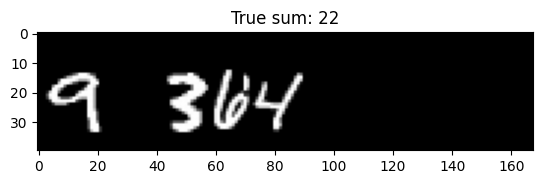

In [40]:
# 9. Prediction on a single sample
idx = 10
img, lbl = val_subset[idx]
plt.imshow(img[0], cmap='gray')
plt.title(f"True sum: {lbl}")
plt.show()

In [41]:
model.eval()
with torch.no_grad():
    img = img.unsqueeze(0).to(device)
    output = model(img)
    pred_sum = torch.argmax(output, dim=1).item()

print("Predicted sum:", pred_sum)

Predicted sum: 17


In [46]:

# Save entire model object (pickling)
torch.save(model, "baseline_model.pth")
